In [ ]:
%tensorflow_version 1.x
import tensorflow as tf


from google.colab import drive

import cv2

from glob import glob
import numpy as np
import os


from IPython.display import clear_output
import matplotlib.pyplot as plt

from sklearn import metrics as skm
import random

from tensorflow.python.ops import math_ops

SIZE = 1024

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
def load_image_paths(dir = '/content/drive/MyDrive/Segmentation/Images/split16'):
  dirs = (os.path.join(dir, 'Training - Images/*.tif'),
          os.path.join(dir, 'Training - Masks/*.tif'),
          os.path.join(dir, 'Test - Images/*.tif'),
          os.path.join(dir, 'Test - Masks/*.tif'))
  return sorted(glob(dirs[0])), sorted(glob(dirs[1])), sorted(glob(dirs[2])), sorted(glob(dirs[3]))  

def load_image(path):
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  x = clahe.apply(cv2.imread(path, flags=cv2.IMREAD_GRAYSCALE))
  x = np.expand_dims((x/255.0).astype(np.float32), axis=2)
  return x

def load_mask(path):
  _, mask = cv2.threshold(cv2.imread(path, flags=cv2.IMREAD_GRAYSCALE), 1, 255, cv2.THRESH_BINARY)
  return np.expand_dims((mask/255.0).astype(np.float32), axis=2)

u, v, test_images, test_masks = load_image_paths()


In [ ]:
def split(image):
  half = 1024//2
  tl = image[:half, :half]
  tr = image[:half, half:]
  bl = image[half:, :half]
  br = image[half:, half:]
  return np.stack([tl, tr, bl, br]) 
ckpt_path = '/content/drive/MyDrive/Segmentation/DesNet Checkpoint'
return_list = None
graph = tf.Graph()
with tf.Session(graph=graph) as sess:
  saver = tf.train.import_meta_graph(ckpt_path + '/checkpoint.ckpt.meta')
  saver.restore(sess, ckpt_path + '/checkpoint.ckpt')
  x_d = split(load_image(test_images[0]))
  fd = {'x:0':x_d, 'lr:0':0, 'is_training:0':True, 'residual_weight:0':0.1}
  fetches = ['out_void:0']
  print([op.name for op in graph.get_operations() if graph.is_fetchable(op)])
  return_list = sess.run(fetches, feed_dict = fd)

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/Segmentation/DesNet Checkpoint/checkpoint.ckpt
['is_training', 'lr', 'x', 'y_true_void', 'x_in', 'residual_weight', 'variable_scope1/concat/concat_dim', 'variable_scope1/concat', 'variable_scope1/Const', 'variable_scope1/MirrorPad', 'variable_scope1/conv2d/kernel/Initializer/random_uniform/shape', 'variable_scope1/conv2d/kernel/Initializer/random_uniform/min', 'variable_scope1/conv2d/kernel/Initializer/random_uniform/max', 'variable_scope1/conv2d/kernel/Initializer/random_uniform/RandomUniform', 'variable_scope1/conv2d/kernel/Initializer/random_uniform/sub', 'variable_scope1/conv2d/kernel/Initializer/random_uniform/mul', 'variable_scope1/conv2d/kernel/Initializer/random_uniform', 'variable_scope1/conv2d/kernel', 'variable_scope1/conv2d/kernel/Assign', 'variable_scope1/conv2d/kernel/read', 'variable_scope1/conv2d/kernel/Regularizer/l2_regularizer/scale', 'variable_scope1/conv2d/kernel/Regularizer/l2_regularizer/L2Loss', 'v

0.86345875
0.2735169


<Figure size 432x288 with 0 Axes>

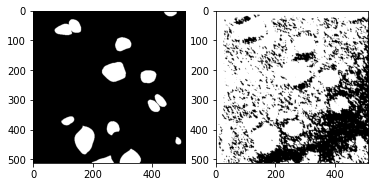

In [ ]:
return_list[0].shape
masks = split(load_mask(test_masks[0]))
learned = (return_list[0])*1.
#learned = learned - np.min(learned)
#learned = learned/(np.max(learned))
learned = 1./(1. + np.exp(-learned))
print(np.max(learned))
print(np.min(learned))
i = 0
t = 0.3
plt.figure()
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(np.squeeze(masks[i], axis=2), cmap = 'gray') 
axarr[1].imshow(np.squeeze((learned[i] > t)*1., axis=2), cmap = 'gray')
plt.show()